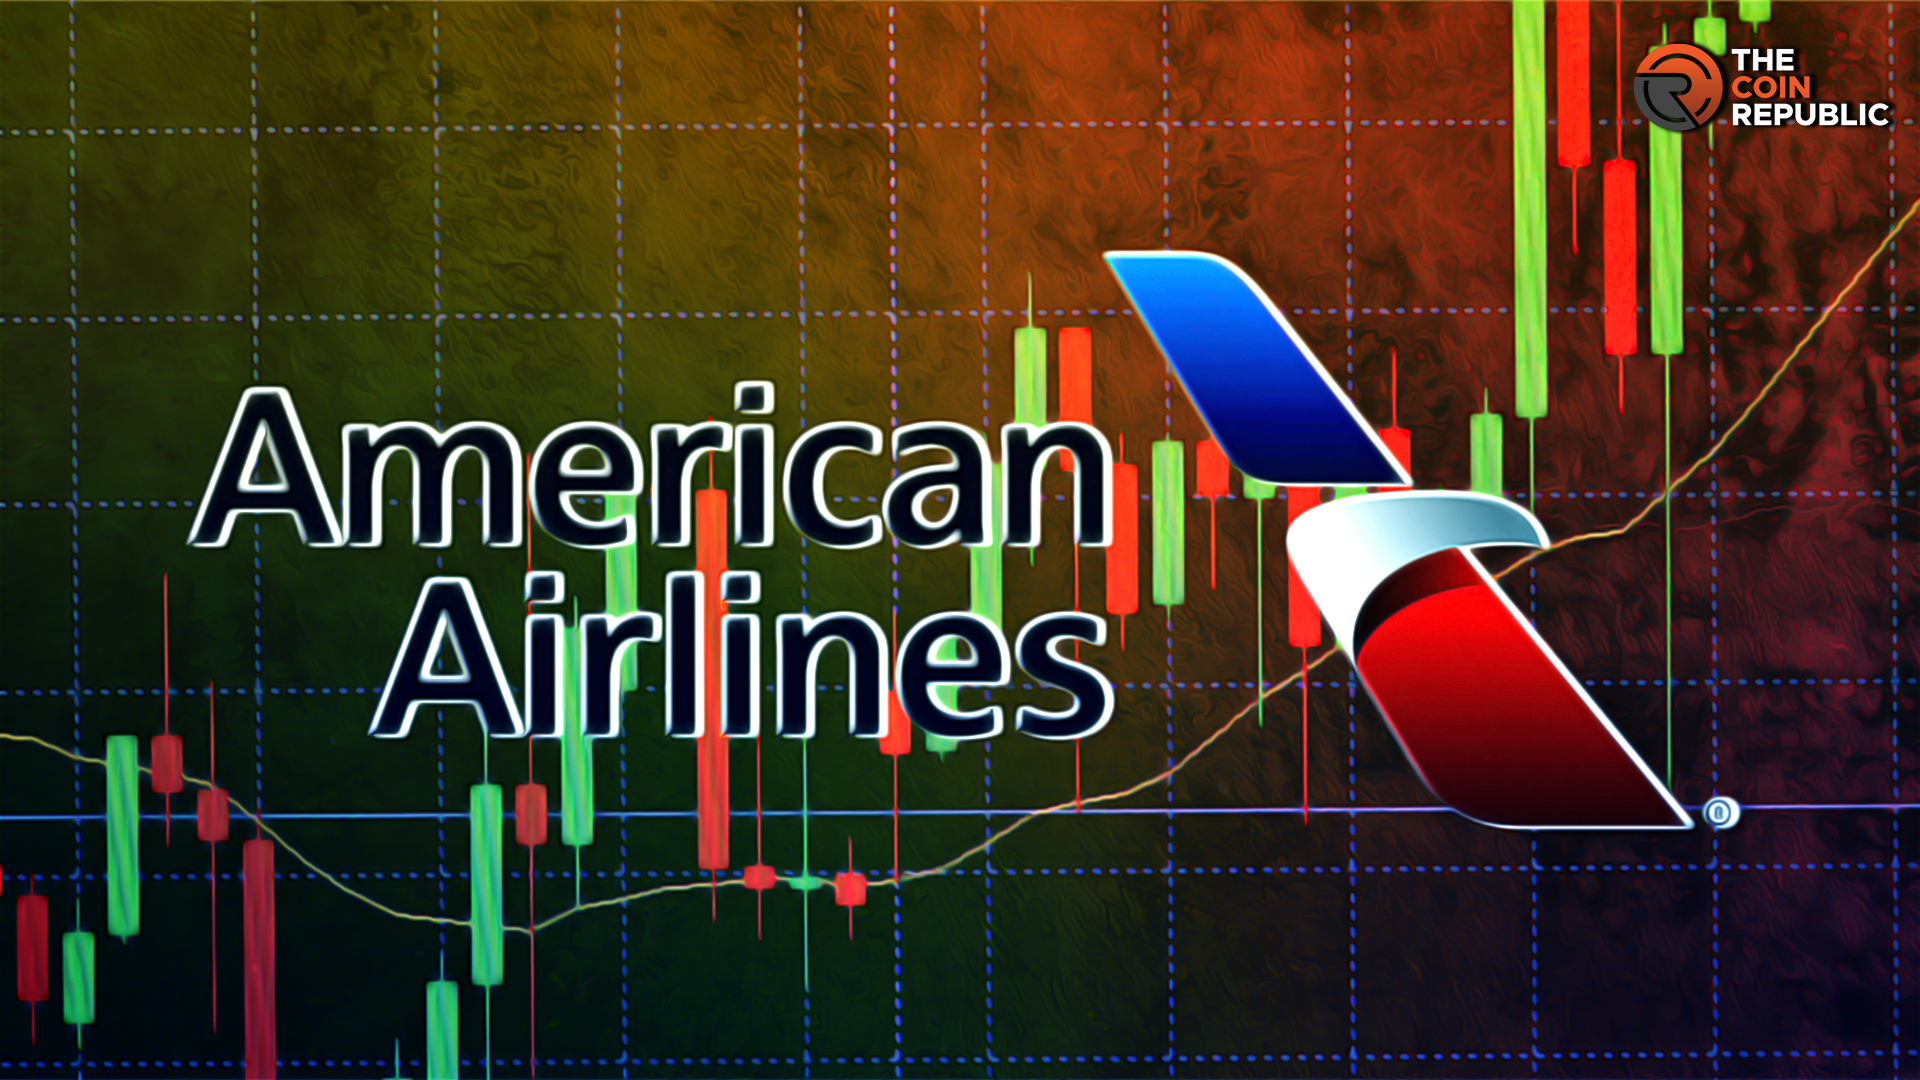

#CONTEXT
Dans le cadre de l'analyse des marchés financiers, la prévision du prix de clôture ajusté des actions d'American Airlines est essentielle pour les investisseurs. Ce prix reflète la valeur réelle des actions après ajustements pour dividendes et fractionnements.

#Objectifs
Développer un modèle LSTM pour prédire les prix de clôture ajustés des actions d'American Airlines, évaluer la précision du modèle avec des métriques telles que RMSE et R², optimiser les hyperparamètres pour améliorer les prévisions, et visualiser les résultats en comparant graphiquement les prévisions avec les valeurs réelles.

#Enjeux
- Précision des Prévisions : Assurer que les prévisions sont fiables pour des décisions éclairées.
- Adaptation aux Variabilités : Réagir aux changements du marché et aux nouvelles tendances.
- Gestion des Risques : Utiliser les prévisions pour mieux gérer les risques d'investissement.

# Importation des librairies necessaires

---



In [2]:
import pandas as pd
import datetime as dt
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model

#Chargement et analyse exploratoire du jeu de données

In [3]:
path = '/content/AAL.1.csv'
data = pd.read_csv(path)
df=data
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Label
0,9/27/2005,21.049999,21.400000,19.100000,19.299999,18.194912,961200,0
1,9/28/2005,19.299999,20.530001,19.200001,20.500000,19.326204,5747900,1
2,9/29/2005,20.400000,20.580000,20.100000,20.209999,19.052807,1078200,0
3,9/30/2005,20.260000,21.049999,20.180000,21.010000,19.806997,3123300,1
4,10/3/2005,20.900000,21.750000,20.900000,21.500000,20.268946,1057900,1


In [4]:
df.shape

(4152, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4152 entries, 0 to 4151
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4152 non-null   object 
 1   Open       4152 non-null   float64
 2   High       4152 non-null   float64
 3   Low        4152 non-null   float64
 4   Close      4152 non-null   float64
 5   Adj Close  4152 non-null   float64
 6   Volume     4152 non-null   int64  
 7   Label      4152 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 259.6+ KB


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Label
count,4152.000000,4152.000000,4152.000000,4152.000000,4152.000000,4.152000e+03,4152.000000
mean,25.898909,26.374256,25.393528,25.871416,24.861094,1.357131e+07,0.468931
std,16.087281,16.275087,15.889804,16.086850,15.425919,2.196484e+07,0.499094
min,1.810000,2.030000,1.450000,1.760000,1.659225,1.385000e+05,0.000000
25%,10.627500,10.907500,10.280000,10.557500,10.049624,4.501425e+06,0.000000
50%,24.545000,25.200000,24.145000,24.460000,23.961385,7.141950e+06,0.000000
75%,40.012499,40.720001,39.412499,40.020000,38.313822,1.188660e+07,1.000000
max,62.700001,63.270000,62.000000,62.950001,59.345585,4.286171e+08,1.000000


In [7]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
Label,0


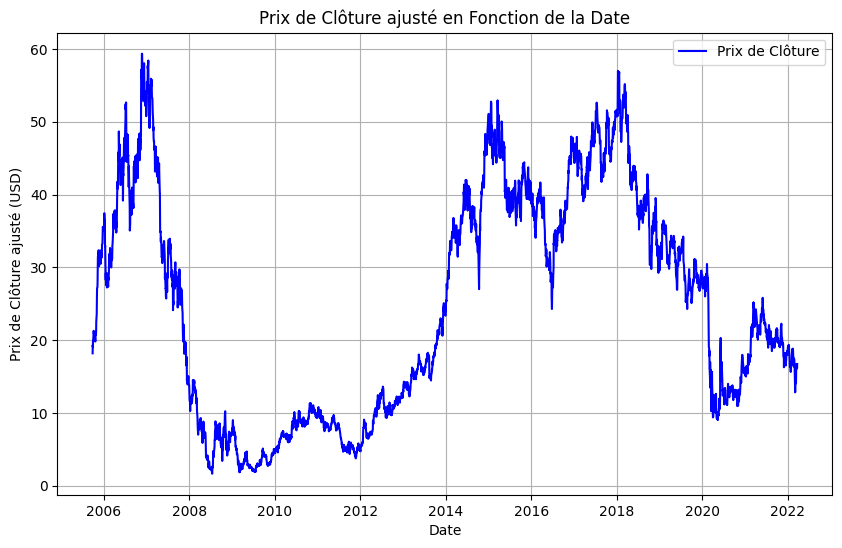

In [8]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Plot the closing price over time
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Adj Close'], label='Prix de Clôture', color='blue')
plt.title('Prix de Clôture ajusté en Fonction de la Date')
plt.xlabel('Date')
plt.ylabel('Prix de Clôture ajusté (USD)')
plt.grid(True)
plt.legend()
plt.show()

**Commentaire sur la courbe**

Ce graphique montre l'évolution du prix de clôture ajusté des actions de 2005 à 2022, caractérisée par trois phases majeures : une forte hausse suivie d'une chute brutale en 2008 liée à la crise financière mondiale, une période de récupération et d'expansion continue jusqu'à un sommet en 2017-2018, et enfin une baisse marquée par des fluctuations entre 2018 et 2022, possiblement influencée par la pandémie de COVID-19. Le graphique illustre la volatilité des marchés financiers, reflétant les cycles économiques et l'impact des crises globales sur les prix des actions.

In [9]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,Label
0,2005-09-27,21.049999,21.400000,19.100000,19.299999,18.194912,961200,0
1,2005-09-28,19.299999,20.530001,19.200001,20.500000,19.326204,5747900,1
2,2005-09-29,20.400000,20.580000,20.100000,20.209999,19.052807,1078200,0
3,2005-09-30,20.260000,21.049999,20.180000,21.010000,19.806997,3123300,1
4,2005-10-03,20.900000,21.750000,20.900000,21.500000,20.268946,1057900,1
...,...,...,...,...,...,...,...,...
4147,2022-03-18,16.350000,16.840000,16.160000,16.750000,16.750000,38979100,1
4148,2022-03-21,16.500000,16.540001,15.900000,16.090000,16.090000,45852600,0
4149,2022-03-22,16.200001,16.760000,16.090000,16.559999,16.559999,40143400,1
4150,2022-03-23,16.309999,16.459999,16.170000,16.209999,16.209999,31336000,0


In [10]:
df = df.drop(['Date'], axis = 1)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Label
0,21.049999,21.400000,19.100000,19.299999,18.194912,961200,0
1,19.299999,20.530001,19.200001,20.500000,19.326204,5747900,1
2,20.400000,20.580000,20.100000,20.209999,19.052807,1078200,0
3,20.260000,21.049999,20.180000,21.010000,19.806997,3123300,1
4,20.900000,21.750000,20.900000,21.500000,20.268946,1057900,1


#Visualisation de la valeur de fermeture ajustée des prix des actions

In [11]:
df

,Open,High,Low,Close,Adj Close,Volume,Label
0,21.049999,21.400000,19.100000,19.299999,18.194912,961200,0
1,19.299999,20.530001,19.200001,20.500000,19.326204,5747900,1
2,20.400000,20.580000,20.100000,20.209999,19.052807,1078200,0
3,20.260000,21.049999,20.180000,21.010000,19.806997,3123300,1
4,20.900000,21.750000,20.900000,21.500000,20.268946,1057900,1
...,...,...,...,...,...,...,...
4147,16.350000,16.840000,16.160000,16.750000,16.750000,38979100,1
4148,16.500000,16.540001,15.900000,16.090000,16.090000,45852600,0
4149,16.200001,16.760000,16.090000,16.559999,16.559999,40143400,1
4150,16.309999,16.459999,16.170000,16.209999,16.209999,31336000,0


# Traçage les moyennes mobiles sur 100 jours.

---



In [12]:
ma100 = df['Adj Close'].rolling(100).mean()
ma100

,Adj Close
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
4147,17.8484
4148,17.8154
4149,17.7907
4150,17.7609


Text(0.5, 1.0, 'les moyennes mobiles sur 100 jours')

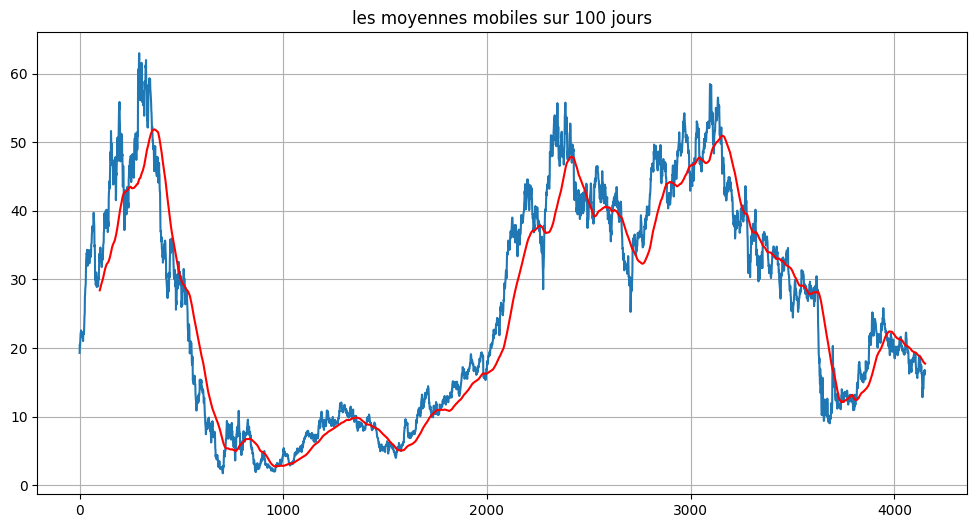

In [13]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.grid(True)
plt.title('les moyennes mobiles sur 100 jours')

# Définition les moyennes mobiles sur 200 jours et tracer un graphique de comparaison avec les moyennes mobiles sur 100 jours.

---



In [14]:
ma200 = df['Adj Close'].rolling(200).mean()
ma200

,Adj Close
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
4147,19.27965
4148,19.23860
4149,19.20015
4150,19.16010


Text(0.5, 1.0, 'Comparaison des moyennes mobiles des 100 et 200 jours')

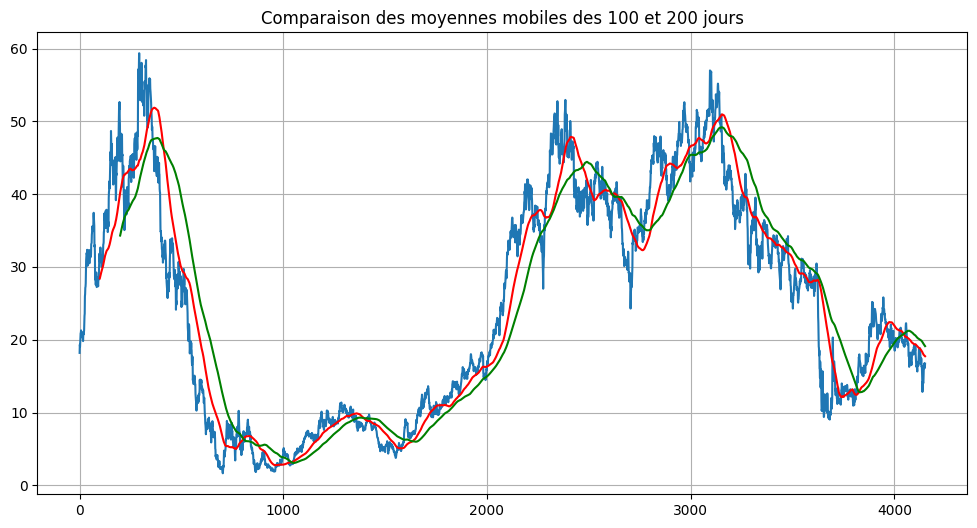

In [15]:
plt.figure(figsize = (12,6))
plt.plot(df['Adj Close'])
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.grid(True)
plt.title('Comparaison des moyennes mobiles des 100 et 200 jours')

***Commentaire sur le graphe***

Lorsque la courbe courte (MM des 100 jours) croise la courbe longue (MM des 200 jours) de bas en haut, cela peut indiquer un signal haussier.Si la courbe courte croise la courbe longue de haut en bas, cela peut signaler une tendance baissière.

 Les MM sont utilisées pour suivre les tendances et identifier les points de retournement.

In [16]:
df.shape

(4152, 7)

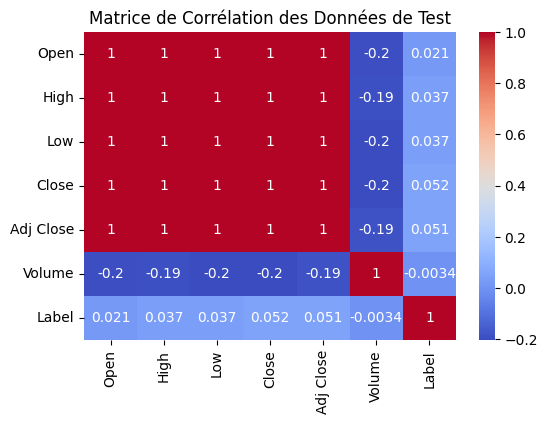

In [17]:
# Calculer la matrice de corrélation
corr_matrix = df.corr()

# Afficher la matrice de corrélation
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de Corrélation des Données de Test')
plt.show()

In [18]:
df = df.drop(['Label'], axis = 1)
df

,Open,High,Low,Close,Adj Close,Volume
0,21.049999,21.400000,19.100000,19.299999,18.194912,961200
1,19.299999,20.530001,19.200001,20.500000,19.326204,5747900
2,20.400000,20.580000,20.100000,20.209999,19.052807,1078200
3,20.260000,21.049999,20.180000,21.010000,19.806997,3123300
4,20.900000,21.750000,20.900000,21.500000,20.268946,1057900
...,...,...,...,...,...,...
4147,16.350000,16.840000,16.160000,16.750000,16.750000,38979100
4148,16.500000,16.540001,15.900000,16.090000,16.090000,45852600
4149,16.200001,16.760000,16.090000,16.559999,16.559999,40143400
4150,16.309999,16.459999,16.170000,16.209999,16.209999,31336000


# Division du jeu de données en ensembles d'entraînement (80 %) et de test (20 %)

In [19]:
#Recueillir la seule colonne 'Adj Close'
data = df['Adj Close']
data = data.values
data
#taille de la données d'entrainement
train_size = int(len(data)*0.80)
train_size

3321

In [20]:
#Normalisation de la données
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data.reshape(-1,1))
scaled_data

array([[0.28664813],
       [0.30625921],
       [0.30151984],
       ...,
       [0.25830671],
       [0.25223942],
       [0.26108033]])

In [21]:
#creation de la dataset d'entrainement
train_data = scaled_data[0:train_size, :]
train_data
#separation en x_train et y_train
x_train = []
y_train = []
for i in range(100, train_data.shape[0]):
    x_train.append(train_data[i-100: i,0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [22]:
x_train,y_train

(array([[0.28664813, 0.30625921, 0.30151984, ..., 0.52279771, 0.51675115,
         0.51299215],
        [0.30625921, 0.30151984, 0.31459381, ..., 0.51675115, 0.51299215,
         0.50236954],
        [0.30151984, 0.31459381, 0.32260176, ..., 0.51299215, 0.50236954,
         0.52100018],
        ...,
        [0.58140774, 0.58768601, 0.6010906 , ..., 0.62443671, 0.63552523,
         0.62665439],
        [0.58768601, 0.6010906 , 0.60380549, ..., 0.63552523, 0.62665439,
         0.65633751],
        [0.6010906 , 0.60380549, 0.60550234, ..., 0.62665439, 0.65633751,
         0.64763728]]),
 array([0.50236954, 0.52100018, 0.53750613, ..., 0.65633751, 0.64763728,
        0.59714182]))

In [23]:
y_train.shape

(3221,)

# ML Model (LSTM)

---



In [24]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences=True
              ,input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))


model.add(LSTM(units = 60, activation = 'relu', return_sequences=True))
model.add(Dropout(0.3))


model.add(LSTM(units = 80, activation = 'relu', return_sequences=True))
model.add(Dropout(0.4))


model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 60)             │          26,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 60)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 80)             │          45,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 80)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 120)                 │          96,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

# Entrainement du modèle




In [26]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train, y_train,epochs = 15)

Epoch 1/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 37s 293ms/step - loss: 0.0798 - mean_absolute_error: 0.1988
Epoch 2/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 294ms/step - loss: 0.0093 - mean_absolute_error: 0.0671
Epoch 3/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 29s 292ms/step - loss: 0.0072 - mean_absolute_error: 0.0595
Epoch 4/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 294ms/step - loss: 0.0076 - mean_absolute_error: 0.0603
Epoch 5/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 293ms/step - loss: 0.0063 - mean_absolute_error: 0.0553
Epoch 6/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 294ms/step - loss: 0.0058 - mean_absolute_error: 0.0544
Epoch 7/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 292ms/step - loss: 0.0054 - mean_absolute_error: 0.0517
Epoch 8/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 295ms/step - loss: 0.0054 - mean_absolute_error: 0.0507
Epoch 9/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 297ms/step - loss: 0.0054 - mean_absolute_error: 0.0511
Epoch 10/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 294ms/step - loss: 0.0053 - mean_absolute_error: 0.0510

In [27]:
model.save('keras_model.h5')

In [28]:
#Creation de la données de test
test_data = scaled_data[train_size - 100:, :]
#creation de la données x_test et y_test
x_test = []
y_test = data[train_size:]
for i in range(100, test_data.shape[0]):
    x_test.append(test_data[i-100: i,0])
x_test,y_test = np.array(x_test), np.array(y_test)
x_test

array([[0.60380549, 0.60550234, 0.6223007 , ..., 0.65633751, 0.64763728,
        0.59714182],
       [0.60550234, 0.6223007 , 0.6182284 , ..., 0.64763728, 0.59714182,
        0.60140662],
       [0.6223007 , 0.6182284 , 0.61398634, ..., 0.59714182, 0.60140662,
        0.54391692],
       ...,
       [0.30112449, 0.30389811, 0.30407147, ..., 0.25813336, 0.2616004 ,
        0.25015922],
       [0.30389811, 0.30407147, 0.31395247, ..., 0.2616004 , 0.25015922,
        0.25830671],
       [0.30407147, 0.31395247, 0.31499257, ..., 0.25015922, 0.25830671,
        0.25223942]])

In [29]:
x_test.shape

(831, 100)

In [30]:
y_test

array([36.352184, 33.035812, 33.301517, 33.557377, 33.803402, 31.943472,
       31.894268, 31.530161, 33.00629 , 31.904114, 31.382545, 30.290211,
       29.247074, 31.776182, 31.530161, 31.323502, 31.599045, 31.963156,
       29.581663, 31.530161, 32.425678, 31.904114, 32.888203, 31.530161,
       31.293976, 31.205408, 31.589203, 32.317429, 33.045654, 33.429451,
       32.219025, 31.146364, 33.124386, 34.423374, 35.988071, 35.712532,
       35.761734, 35.200802, 35.535397, 36.194733, 36.441425, 36.273674,
       35.691483, 35.523731, 36.105927, 35.277035, 35.730949, 35.632275,
       34.586296, 35.00074 , 34.596169, 34.517223, 35.020477, 35.425053,
       35.770424, 35.217827, 35.158623, 34.181721, 33.273895, 32.790375,
       32.326591, 31.793739, 31.487839, 31.625984, 30.510935, 31.418764,
       31.704926, 31.014189, 30.964849, 31.172071, 30.550406, 31.033926,
       30.165565, 29.810328, 29.810328, 30.530672, 30.491199, 31.339825,
       31.922014, 32.553551, 33.264027, 33.481117, 

# Faire des prédictions et tracer le graphique des valeurs prédites par rapport aux valeurs réelles


In [31]:
# Making predictions
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
y_pred

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step


array([[35.17014  ],
       [35.33524  ],
       [35.38767  ],
       [35.291485 ],
       [35.04958  ],
       [34.692947 ],
       [34.2448   ],
       [33.733063 ],
       [33.18366  ],
       [32.63794  ],
       [32.12271  ],
       [31.651472 ],
       [31.222137 ],
       [30.82192  ],
       [30.462479 ],
       [30.158125 ],
       [29.918549 ],
       [29.750025 ],
       [29.65769  ],
       [29.60965  ],
       [29.595957 ],
       [29.623312 ],
       [29.69076  ],
       [29.803614 ],
       [29.944437 ],
       [30.0888   ],
       [30.21489  ],
       [30.313442 ],
       [30.391273 ],
       [30.467022 ],
       [30.560236 ],
       [30.666464 ],
       [30.760841 ],
       [30.845472 ],
       [30.943804 ],
       [31.094728 ],
       [31.318766 ],
       [31.615314 ],
       [31.959328 ],
       [32.323017 ],
       [32.6881   ],
       [33.042286 ],
       [33.37257  ],
       [33.659874 ],
       [33.887714 ],
       [34.055527 ],
       [34.15888  ],
       [34.20

In [32]:
y_pred.shape

(831, 1)

In [33]:
y_test

array([36.352184, 33.035812, 33.301517, 33.557377, 33.803402, 31.943472,
       31.894268, 31.530161, 33.00629 , 31.904114, 31.382545, 30.290211,
       29.247074, 31.776182, 31.530161, 31.323502, 31.599045, 31.963156,
       29.581663, 31.530161, 32.425678, 31.904114, 32.888203, 31.530161,
       31.293976, 31.205408, 31.589203, 32.317429, 33.045654, 33.429451,
       32.219025, 31.146364, 33.124386, 34.423374, 35.988071, 35.712532,
       35.761734, 35.200802, 35.535397, 36.194733, 36.441425, 36.273674,
       35.691483, 35.523731, 36.105927, 35.277035, 35.730949, 35.632275,
       34.586296, 35.00074 , 34.596169, 34.517223, 35.020477, 35.425053,
       35.770424, 35.217827, 35.158623, 34.181721, 33.273895, 32.790375,
       32.326591, 31.793739, 31.487839, 31.625984, 30.510935, 31.418764,
       31.704926, 31.014189, 30.964849, 31.172071, 30.550406, 31.033926,
       30.165565, 29.810328, 29.810328, 30.530672, 30.491199, 31.339825,
       31.922014, 32.553551, 33.264027, 33.481117, 

In [34]:
y_test.shape

(831,)

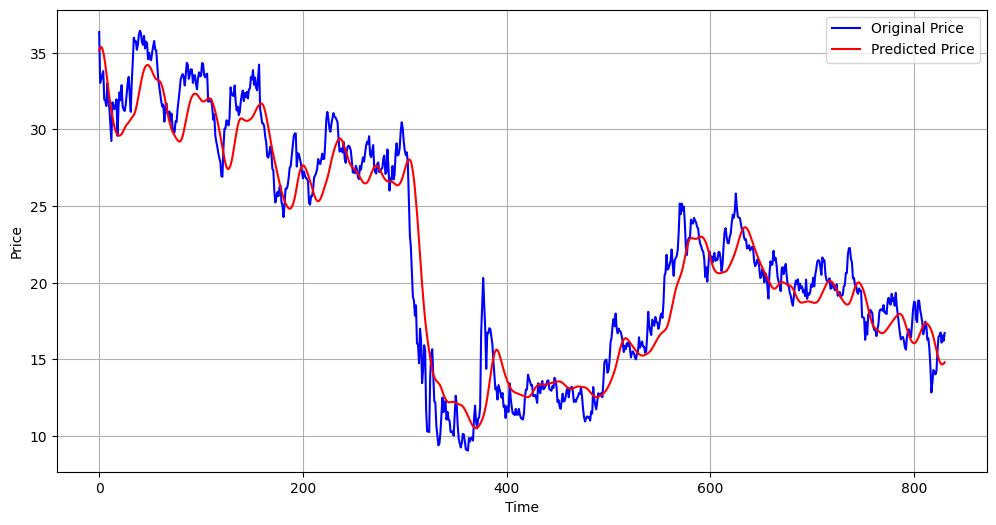

In [35]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation du model

Calculation of mean absolute error

In [36]:
mae = mean_absolute_error(y_test, y_pred)
mae_percentage = (mae / np.mean(y_test)) * 100
print("Mean absolute error on test set: {:.2f}%".format(mae_percentage))

Mean absolute error on test set: 6.96%


Calculation of R2 score

In [37]:
# Actual values
actual = y_test

# Predicted values
predicted = y_pred

# Calculate the R2 score
r2 = r2_score(actual, predicted)

print("R2 score:", r2)

R2 score: 0.9242097642414453


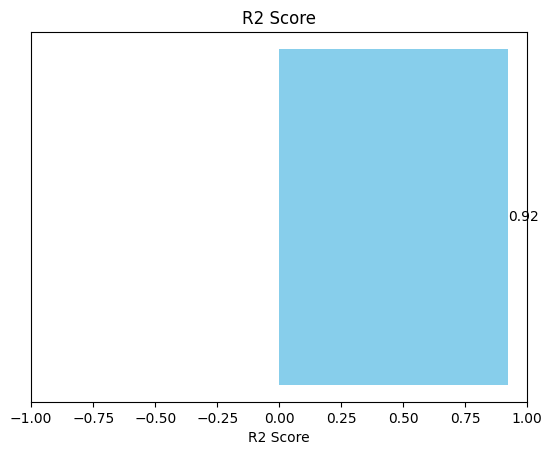

In [38]:
# Plotting the R2 score
fig, ax = plt.subplots()
ax.barh(0, r2, color='skyblue')
ax.set_xlim([-1, 1])
ax.set_yticks([])
ax.set_xlabel('R2 Score')
ax.set_title('R2 Score')

# Adding the R2 score value on the bar
ax.text(r2, 0, f'{r2:.2f}', va='center', color='black')

plt.show()

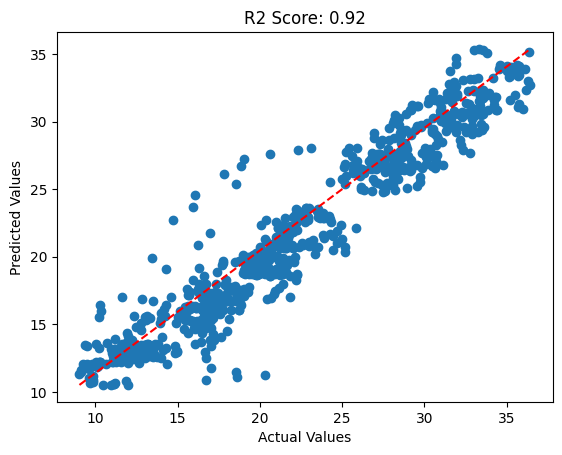

In [39]:
plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R2 Score: {r2:.2f}')
plt.show()

#Nouveau jeu de données pour prédire la nouvelle valeur du prix d'action ajusté de l'AAL

In [40]:
def predict_next_value_with_date(new_data, model_path='/content/keras_model.h5'):
    """
    Prédit la prochaine valeur en fonction des nouvelles données et d'un modèle LSTM préalablement entraîné,
    et retourne la valeur prédite avec la date associée.

    :param new_data: DataFrame contenant les nouvelles données, incluant une colonne 'Date' et 'Close'.
    :param model_path: Chemin du modèle LSTM sauvegardé.
    :return: Un tuple (date_prédiction, valeur_prédite).
    """

    # Charger le modèle LSTM entraîné
    model = load_model(model_path)

    # Extraire les dates et les prix de clôture
    dates = new_data['Date'].values
    new_close_prices = new_data['Adj Close'].values.reshape(-1, 1)

    # Normaliser les données
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_new_close = scaler.fit_transform(new_close_prices)

    # Créer la séquence des 100 derniers jours pour la prédiction
    sequence_length = 100
    last_sequence = scaled_new_close[-sequence_length:]

    # Reshape pour correspondre à l'entrée attendue par le LSTM
    last_sequence = last_sequence.reshape((1, sequence_length, 1))

    # Faire la prédiction
    predicted_scaled_price = model.predict(last_sequence)

    # Inverser la normalisation pour obtenir la prédiction en échelle originale
    predicted_price = scaler.inverse_transform(predicted_scaled_price)[0][0]

    # La date associée à la prédiction est le jour suivant la dernière date de la séquence
    prediction_date = pd.to_datetime(dates[-1]) + pd.DateOffset(1)

    return prediction_date, predicted_price

#Exemple d'utilisation
nouvelle_data = pd.read_csv('/content/AAL.csv')
prediction_date, prediction_value = predict_next_value_with_date(nouvelle_data)
print(f"Le prix prédit pour {prediction_date.strftime('%Y-%m-%d')} est : {prediction_value}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
Le prix prédit pour 2024-08-10 est : 10.345301628112793


#Conclusion

Ce projet développe un modèle avancé pour prédire les prix de clôture ajustés des actions d'American Airlines. Les prévisions obtenues aideront à prendre des décisions d'investissement plus informées, tout en soulignant l'importance de la gestion des risques et de l'adaptation continue aux évolutions du marché.


merci.avif